In [1]:
import pandas as pd
import numpy as np
import scipy
import re
import random
import warnings # to deal with warnings

from math import sqrt

from scipy.linalg import cho_factor, cho_solve
from scipy.stats import boxcox

from sklearn import datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV # for LASSO

import matplotlib.pyplot as plt # for hist()
from plotnine import *

# Read in Data

In [2]:
data = pd.read_csv("./data/SpotifyData.csv")
df = pd.DataFrame(data)
df.head(5)

,title,artist,top genre,year released,added,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top year,artist type
0,STARSTRUKK (feat. Katy Perry),3OH!3,dance pop,2009.0,2022‑02‑17,140.0,81.0,61.0,-6.0,23.0,23.0,203.0,0.0,6.0,70.0,2010.0,Duo
1,My First Kiss (feat. Ke$ha),3OH!3,dance pop,2010.0,2022‑02‑17,138.0,89.0,68.0,-4.0,36.0,83.0,192.0,1.0,8.0,68.0,2010.0,Duo
2,I Need A Dollar,Aloe Blacc,pop soul,2010.0,2022‑02‑17,95.0,48.0,84.0,-7.0,9.0,96.0,243.0,20.0,3.0,72.0,2010.0,Solo
3,Airplanes (feat. Hayley Williams of Paramore),B.o.B,atl hip hop,2010.0,2022‑02‑17,93.0,87.0,66.0,-4.0,4.0,38.0,180.0,11.0,12.0,80.0,2010.0,Solo
4,Nothin' on You (feat. Bruno Mars),B.o.B,atl hip hop,2010.0,2022‑02‑17,104.0,85.0,69.0,-6.0,9.0,74.0,268.0,39.0,5.0,79.0,2010.0,Solo


In [3]:
A = df.iloc[:-3, [2,5,6,7,8,9,10,11,12,13,14,15,16]] # last 3 rows are all NAs; want bpm to pop columns
A.insert(0, "intercept", 1, True) # insert row of 1s for intercept
A.head(10)

,intercept,top genre,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top year,artist type
0,1,dance pop,140.0,81.0,61.0,-6.0,23.0,23.0,203.0,0.0,6.0,70.0,2010.0,Duo
1,1,dance pop,138.0,89.0,68.0,-4.0,36.0,83.0,192.0,1.0,8.0,68.0,2010.0,Duo
2,1,pop soul,95.0,48.0,84.0,-7.0,9.0,96.0,243.0,20.0,3.0,72.0,2010.0,Solo
3,1,atl hip hop,93.0,87.0,66.0,-4.0,4.0,38.0,180.0,11.0,12.0,80.0,2010.0,Solo
4,1,atl hip hop,104.0,85.0,69.0,-6.0,9.0,74.0,268.0,39.0,5.0,79.0,2010.0,Solo
5,1,atl hip hop,82.0,93.0,55.0,-4.0,35.0,79.0,196.0,1.0,34.0,71.0,2010.0,Solo
6,1,dance pop,128.0,81.0,82.0,-8.0,60.0,44.0,308.0,7.0,7.0,75.0,2010.0,Band/Group
7,1,dance pop,92.0,52.0,60.0,-7.0,31.0,41.0,258.0,18.0,37.0,71.0,2010.0,Band/Group
8,1,dance pop,146.0,59.0,50.0,-5.0,11.0,8.0,218.0,51.0,3.0,87.0,2010.0,Solo
9,1,dance pop,109.0,84.0,64.0,-5.0,6.0,42.0,221.0,1.0,4.0,86.0,2010.0,Solo


Since the `top genre` has a large number of categories and a lot of "niche" genres with only a few entries, we recode the variable so that the categories are broader.

In [4]:
A['top genre'] = A['top genre'].astype(str)
mapping = ['dance pop', 'pop', 'hip hop', 'rap', 'rock', 'r&b', 'house', 'dance', 'indie', 'edm', 'country', 'boy band']
A['top genre broad'] = A['top genre'].apply(lambda x: [k for k in mapping if re.search(k, x)])
A['top genre broad'] = A['top genre broad'].str[0]
A["top genre broad"].fillna('other', inplace=True)
A = A.drop(["top genre"], axis=1)
A.head(5)

,intercept,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,pop,top year,artist type,top genre broad
0,1,140.0,81.0,61.0,-6.0,23.0,23.0,203.0,0.0,6.0,70.0,2010.0,Duo,dance pop
1,1,138.0,89.0,68.0,-4.0,36.0,83.0,192.0,1.0,8.0,68.0,2010.0,Duo,dance pop
2,1,95.0,48.0,84.0,-7.0,9.0,96.0,243.0,20.0,3.0,72.0,2010.0,Solo,pop
3,1,93.0,87.0,66.0,-4.0,4.0,38.0,180.0,11.0,12.0,80.0,2010.0,Solo,hip hop
4,1,104.0,85.0,69.0,-6.0,9.0,74.0,268.0,39.0,5.0,79.0,2010.0,Solo,hip hop


Label encode the categorical variables:

In [5]:
label_encoder = preprocessing.LabelEncoder()
A["top year"] = label_encoder.fit_transform(A["top year"])
A["artist type"] = label_encoder.fit_transform(A["artist type"])
A["top genre broad"] = label_encoder.fit_transform(A["top genre broad"])

Due to the response variable violating the normality assumption, a transformation is carried out:

In [6]:
pt = preprocessing.PowerTransformer(method="yeo-johnson")
pop_df = pd.DataFrame(A["pop"])
pt.fit(pop_df)
print(pt.lambdas_)  # optimal lambda value

[3.27087407]


In [7]:
transformed_data = pt.transform(pop_df)
A["pop"] = transformed_data

In [8]:
A = A[[col for col in A if col not in ["pop"]] + ["pop"]] # move 'pop' column to last column
A.head(5)

,intercept,bpm,nrgy,dnce,dB,live,val,dur,acous,spch,top year,artist type,top genre broad,pop
0,1,140.0,81.0,61.0,-6.0,23.0,23.0,203.0,0.0,6.0,0,1,3,-0.688503
1,1,138.0,89.0,68.0,-4.0,36.0,83.0,192.0,1.0,8.0,0,1,3,-0.893216
2,1,95.0,48.0,84.0,-7.0,9.0,96.0,243.0,20.0,3.0,0,2,9,-0.470267
3,1,93.0,87.0,66.0,-4.0,4.0,38.0,180.0,11.0,12.0,0,2,5,0.547680
4,1,104.0,85.0,69.0,-6.0,9.0,74.0,268.0,39.0,5.0,0,2,5,0.407101


# Finding Regression Coefficients and their Standard Errors

### LU Decomposition

In [9]:
X = np.array(A.drop(columns=["pop"])) # all columns but pop
y = np.array(A["pop"]) # pop is response var

XtX = np.matrix.transpose(X).dot(X)
Xty = np.matrix.transpose(X).dot(y)

B_lu = np.linalg.solve(XtX, Xty)
B_lu

array([ 1.57548284e-01,  6.95900710e-05, -1.31937493e-02, -1.91301479e-04,
        2.18890551e-02, -4.56928329e-03,  4.87157339e-03,  1.47873996e-03,
        9.21248437e-04,  1.28768974e-03,  7.46445076e-02, -7.49514683e-02,
        2.59406123e-02])

In [10]:
np.linalg.eigvals(XtX)

array([7.70047043e+07, 1.08969347e+06, 5.82767067e+05, 4.19067094e+05,
       2.12545947e+05, 1.87575493e+05, 1.42296639e+05, 7.63983001e+04,
       1.07328359e+04, 6.62554593e+03, 2.67378594e+03, 4.08904827e+00,
       5.51453310e+02])

For the standard errors, we will first find an estimate of the variance using the formula $\hat{\sigma}^2 = (Y - X\hat{\beta})'(Y - X\hat{\beta})/(n-p)$:

In [11]:
S = y - X.dot(B_lu)
n = X.shape[0] # number of rows of X
p = X.shape[1] # number of rows of X

sigma2_hat = np.matrix.transpose(S).dot(S) / (n-p)
sigma2_hat

0.8913356063590618

Next we implement the formula $SE[\hat{\beta}] = \sqrt{\sigma^2 diag((X^TX)^{-1})}$ using `np.linalg.solve()` to find the inverse of $X^TX$:

In [12]:
a = sigma2_hat * np.diag(np.linalg.inv(XtX))
np.sqrt(a)

array([0.46667529, 0.00117866, 0.00309783, 0.0026423 , 0.02174191,
       0.0022893 , 0.00163561, 0.00078959, 0.00183738, 0.00345919,
       0.0117021 , 0.04061169, 0.00965389])

### Cholesky Decomposition

In [13]:
# using cho_factor() to obtain the lower-triangular Cholesky decomposition for X'X; equates to LL'
L, Lt = cho_factor(XtX, lower = True)

B_chol = cho_solve((L, Lt), Xty)
B_chol

array([ 1.57548284e-01,  6.95900710e-05, -1.31937493e-02, -1.91301479e-04,
        2.18890551e-02, -4.56928329e-03,  4.87157339e-03,  1.47873996e-03,
        9.21248437e-04,  1.28768974e-03,  7.46445076e-02, -7.49514683e-02,
        2.59406123e-02])

We will then find the estimate of the variance for the standard errors. 

In [14]:
aug_mat = np.array(A)
AtA = np.matrix.transpose(aug_mat).dot(aug_mat) # to ensure square matrix

L, Lt = cho_factor(AtA, lower = True)

d = L[L.shape[0]-1, L.shape[1]-1] # d is bottom right element of the lower triangular matrix

n = X.shape[0] # number of rows of X
p = X.shape[1] # number of cols of X

sigma2_hat = d**2/(n - p)
sigma2_hat

0.8913356063590631

In [15]:
L = np.linalg.cholesky(XtX)
a = sigma2_hat * np.diag(scipy.linalg.inv(L @ L.transpose()))
np.sqrt(a)

array([0.46667529, 0.00117866, 0.00309783, 0.0026423 , 0.02174191,
       0.0022893 , 0.00163561, 0.00078959, 0.00183738, 0.00345919,
       0.0117021 , 0.04061169, 0.00965389])

# LASSO

In [16]:
warnings.filterwarnings("ignore")  # supress warnings about using iloc
X = pd.DataFrame(X) # make numpy array into pandas df

list_numerical = X.columns[:9] # get names of numerical columns only; CHECK IF CORRECT

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10
)

# Standardize Values
scaler = preprocessing.StandardScaler().fit(X_train[list_numerical])
X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

Text(0.5, 1.0, 'LASSO Coefficients vs Regularization Parameters')

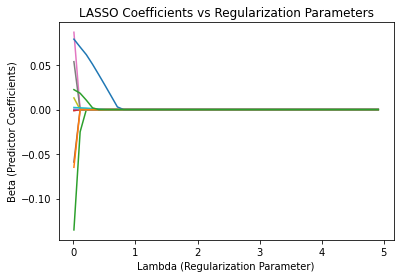

In [17]:
# Graph
coef = []
alphas = np.arange(0.01, 5, 0.10)
lasso = Lasso(max_iter=10000)

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coef.append(lasso.coef_)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(alphas, coef)
ax.set_xlabel("Lambda (Regularization Parameter)")
ax.set_ylabel("Beta (Predictor Coefficients)")
ax.set_title("LASSO Coefficients vs Regularization Parameters")

In [18]:
# K Fold Cross Validation
model = LassoCV(cv=10, random_state=1, max_iter=10000)
model.fit(X_train, y_train)
pred = model.predict(X_test)
residuals = y_test - pred
optimal = model.alpha_
display(optimal)

0.014753783496431739

In [19]:
coefs = np.array(model.coef_)
comp = pd.DataFrame((X_test.columns, coefs)).T
comp = comp.rename({0: "Variable", 1: "Coef"}, axis=1)
display(comp)
display(X_test.columns)

new_pred = model.predict(X_test)
new_resid = y_test - new_pred

,Variable,Coef
0,0.0,0.000000
1,1.0,0.000000
2,2.0,-0.129133
3,3.0,-0.000000
4,4.0,0.000000
5,5.0,-0.055721
6,6.0,0.078166
7,7.0,0.047431
8,8.0,0.010546
9,9.0,0.002267


RangeIndex(start=0, stop=13, step=1)

In [20]:
comp_selected = comp[comp['Coef'] != 0]
selected_features = comp_selected.Variable.unique()
selected_features

array([ 2.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [21]:
y = pd.DataFrame(y) # numpy array to pandas df
LASSO_df = pd.concat([X[selected_features], y], axis=1)
LASSO_df.head()

,2,5,6,7,8,9,10,11,12,0
0,81.0,23.0,23.0,203.0,0.0,6.0,0.0,1.0,3.0,-0.688503
1,89.0,36.0,83.0,192.0,1.0,8.0,0.0,1.0,3.0,-0.893216
2,48.0,9.0,96.0,243.0,20.0,3.0,0.0,2.0,9.0,-0.470267
3,87.0,4.0,38.0,180.0,11.0,12.0,0.0,2.0,5.0,0.547680
4,85.0,9.0,74.0,268.0,39.0,5.0,0.0,2.0,5.0,0.407101


# Simulation Study

In [22]:
#num of observations
#n = 1000
# num of features
#p = 9
# determine the design matrix
#random.seed(108)

#X = np.array(np.random.normal(0, 1, n*p))
#X = X.reshape(n,p)

#beta = B_lu # beta coefficients from above
#sigma = 10

#y = X.dot(beta) + np.random.normal(0, sigma, n)

In [23]:
random.seed(108)

n = 1000
p = 13

cols = A.columns.drop("pop")
X = np.array(
    [np.random.choice(A[x], 1000) for x in cols]
).T

X
X = X.reshape(n,p)
beta = B_lu # beta coefficients from above
sigma = 10

y = X.dot(beta) + np.random.normal(0, sigma, n)

In [24]:
XtX = np.matrix.transpose(X).dot(X)
Xty = np.matrix.transpose(X).dot(y)

beta_est = np.linalg.solve(XtX, Xty)

S = y - X.dot(beta_est)
n = X.shape[0] # number of rows of X
p = X.shape[1] # number of rows of X

var = np.matrix.transpose(S).dot(S) / (n-p)
sigma_est = np.sqrt(var)

In [25]:
pd.DataFrame(data={"True Beta": beta, "Beta Est": beta_est})

,True Beta,Beta Est
0,0.157548,-1.415839
1,0.000070,0.012419
2,-0.013194,-0.020549
3,-0.000191,0.005246
4,0.021889,-0.115218
5,-0.004569,0.013137
6,0.004872,0.026628
7,0.001479,-0.005604
8,0.000921,-0.035179
9,0.001288,0.020352


In [26]:
print("True Sigma: " + str(sigma) + "\nEst sigma: "+str(sigma_est))

True Sigma: 10
Est sigma: 9.730361728587816


In [27]:
#num_datasets = 100
#y_bar = X.dot(beta)
#Y = [y_bar+np.random.normal(0, sigma, n) for i in range(num_datasets)]
#Y = np.concatenate(Y, axis=0 )
#Y = Y.reshape(n, 100)

In [28]:
num_datasets = 100

#cols = A.columns.drop("pop")
#print(cols)
#X_old = np.array([np.random.choice(A[x], 1000) for x in cols]).T

X = np.array([np.random.choice(A["bpm"], 1000)])
fin_mat = X

for i in range(num_datasets):
    cols = A.columns.drop(["bpm", "pop"])
    X = np.array([np.random.choice(A[x], 1000) for x in cols])
    fin_mat = np.vstack([fin_mat, X])
X = fin_mat.T
print(X.shape)

y = np.array([np.random.choice(A["pop"], 1000)]).T

(1000, 1201)


In [29]:
XtX = np.matrix.transpose(X).dot(X)
Xty = np.matrix.transpose(X).dot(y)
Beta =  np.linalg.solve(XtX, Xty)


n = X.shape[0] # number of rows of X
p = X.shape[1] # number of cols of X
S = (y - X @ Beta)**2
Sigma = np.sqrt(S.sum(axis = 0)/(n-p))
Sigma

LinAlgError: Singular matrix

In [ ]:
beta_df = pd.DataFrame(Beta)
beta_df.head(20)
# source: https://stackoverflow.com/questions/50529022/pandas-melt-unmelt-preserve-index

In [ ]:
beta_df2 = pd.melt(beta_df.reset_index(), id_vars="index").drop("variable", axis = 1)
beta_df2.head(20)

In [ ]:
(
ggplot(beta_df2) 
    + geom_histogram(aes(x="value"), bins = 10) 
    + facet_wrap("index", scales = "free_x")
    + geom_vline(xintercept = B_lu.mean(), colour = "blue")
    + geom_vline(xintercept = beta_df2.value.mean(), color = "red")
)

In [ ]:
(
ggplot() 
    + geom_histogram(aes(Sigma), bins = 15) 
    + geom_vline(xintercept = 10, color = 'blue')
    + geom_vline(xintercept = Sigma.mean(), color = 'red')
)